In [4]:
import os
import cv2
import pickle
import argparse
import numpy as np
import glob
from tqdm import tqdm
import sift
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In /home/aman/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/aman/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/aman/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/aman/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/aman/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

In [17]:
sam_labelImagesDir = "../images/samuel_adams/database/"
sam_descriptorsPath = "../lookup/samadams_sift.pkl"
sam_queryImagesPath = "../images/samuel_adams/query/"

### Computing Decriptors for Label Images

In [18]:
def get_descriptors(databaseImagesPath):

    descriptors = dict()
    name_list = []
    for image_name in tqdm(os.listdir(databaseImagesPath)):
        img = cv2.imread(databaseImagesPath+image_name,0)
        print(image_name)
        keypoint, descriptor = sift.detectAndCompute(img)
        img_name,img_extension = os.path.splitext(image_name)
        descriptors[img_name] = descriptor
        name_list.append(img_name)
    return descriptors,name_list

In [ ]:
database_descriptors,name_list = get_descriptors(sam_labelImagesDir)

### Storing Descriptors

In [ ]:
# writing descriptors back
with open(sam_descriptorsPath, 'wb') as file:
        pickle.dump(database_descriptors, file)

### Loading Precomputed Descriptors

In [57]:
with open(sam_descriptorsPath, 'rb') as file:
        database_descriptors = pickle.load(file)

### Finding Number Of Matches B/W Labels And Bottles

In [26]:
def count_matches(queryImagesPath,database_descriptors):
    GOOD_MATCH_THRESH = 10
    
    correct_count = 0

    for query_name in tqdm(os.listdir(queryImagesPath)):
        max_count_name = None
        max_count = 0
        query = cv2.imread(queryImagesPath+query_name, 0)
        _, q_desc = sift.detectAndCompute(query)
        for database_name in database_descriptors.keys():
            d_desc = database_descriptors[database_name]
            FLANN_INDEX_KDTREE = 0
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks = 100)
            flann = cv2.FlannBasedMatcher(index_params, search_params)
            matches = flann.knnMatch(q_desc, d_desc, k=2)
            matches_mask = [[0, 0] for i in range(len(matches))]
            distances = list()
            counts = list()
            for i, (m, n) in enumerate(matches):
                if m.distance < 0.7 * n.distance:
                    matches_mask[i] = [1, 0]
                    distances.append(m.distance)
            counts.append(len(distances))
            if len(distances) != 0:
                if np.max(counts) > max_count:
                    max_count = np.max(counts)
                    max_count_name = database_name.split('/')[-1].split('.')[0]
        if query_name.split('/')[-1].split('.')[0] == max_count_name:
            correct_count += 1
        else:
            print('[ERROR] database_image: {}, query_image: {}'.format(max_count_name, query_name.split('/')[-1].split('.')[0]))
    return correct_count,count

In [ ]:
match_count,total_imgs = count_matches(sam_queryImagesPath,database_descriptors)
print("Match_Count:{0}, Total_images:{1}".format(match_count,total_imgs))

### Creating Motion Images

In [32]:
def convolve(img,kernel):
  k = kernel.shape[0]
  pad_len = int(k / 2)
  convoluted_img = np.copy(img)
  convoluted_img = convoluted_img.astype('int32')
  padded_img = np.pad(convoluted_img, ((pad_len,),(pad_len,)), 'constant',constant_values = 0)
  for i in range(pad_len,padded_img.shape[0] - pad_len):
    for j in range(pad_len,padded_img.shape[1] - pad_len):
      sub_img = padded_img[i-pad_len:i+pad_len+1,j-pad_len:j+pad_len+1]
      convoluted_img[i-pad_len,j-pad_len] = np.sum(np.multiply(sub_img,kernel))
  #convoluted_img =  convoluted_img * (255 / np.max(convoluted_img))
  return convoluted_img

In [40]:
def get_kernel(angle,k):
  kernel = np.zeros((k,k))
  if angle == 0:
    kernel[int(k/2),:] = 1
  elif angle == 45:
    for i in range(k):
      kernel[i,k-i-1] = 1
  else:
    kernel[:,int(k/2)] = 1
  return kernel

In [64]:
def motionBlurImage(imgPath,kernel):
  img = cv2.imread(imgPath,0)
  cImg = convolve(img,kernel)
  img = cv2.normalize(cImg, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  return img

(400, 400)


Text(0.5, 1.0, 'motionBlurredImage')

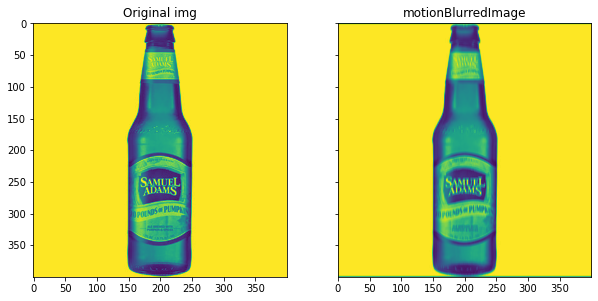

In [53]:
import cv2
import matplotlib.pyplot as plt

kernel_size = 5
kernel = get_kernel(90,kernel_size)
imgPath = '../images/samuel_adams/query/samuel_adams_20_pounds_pumpkin.jpg'

img = cv2.imread(imgPath,0)
motionBlurredImage = motionBlurImage(imgPath,kernel)

f, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(10,10))
ax1.imshow(img)
ax1.set_title("Original img")
ax2.imshow(motionBlurredImage)
ax2.set_title("motionBlurredImage")

In [61]:
def isMatchedCorrect(queryImagePath,motionImg,database_descriptors):
    
    q_key, q_desc = sift.detectAndCompute(motionImg)

    max_count = 0
    max_count_name = None
    for database_name in database_descriptors.keys():
        d_desc = database_descriptors[database_name]
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 100)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(q_desc, d_desc, k=2)
        matches_mask = [[0, 0] for i in range(len(matches))]
        distances = list()
        counts = list()
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                matches_mask[i] = [1, 0]
                distances.append(m.distance)
        counts.append(len(distances))
        if len(distances) != 0:
            if np.max(counts) > max_count:
                max_count = np.max(counts)
                max_count_name = database_name.split('/')[-1].split('.')[0]
    if queryImagePath.split('/')[-1].split('.')[0] == max_count_name:
            return True
    return False

In [65]:

sam_labelImagesDir = "../images/samuel_adams/database/*"
sam_queryImagesPath = "../images/samuel_adams/query/*"

query_images = glob.glob(sam_queryImagesPath)

angles = [0,45,90]
kernel_size = [3,5,7,11,15]
main_lst = []
for angle in angles:
  angle_lst = []
  for k in kernel_size:
    kernel = get_kernel(angle,k)
    count = 0
    for query_name in query_images:
      motionBlurredImage = motionBlurImage(query_name,kernel)
      
      if(isMatchedCorrect(query_name,motionBlurredImage,database_descriptors)):
        count += 1
    print("Angle:{0}, Kernel_size:{1}, count:{2}".format(angle,k,count))
    angle_lst.append(count)
  main_lst.append(angle_lst)

Angle:0, Kernel_size:3, count:29
Angle:0, Kernel_size:5, count:24
Angle:0, Kernel_size:7, count:20
Angle:0, Kernel_size:11, count:13
Angle:0, Kernel_size:15, count:8
Angle:45, Kernel_size:3, count:28
Angle:45, Kernel_size:5, count:23
Angle:45, Kernel_size:7, count:15
Angle:45, Kernel_size:11, count:14
Angle:45, Kernel_size:15, count:10
Angle:90, Kernel_size:3, count:29
Angle:90, Kernel_size:5, count:26
Angle:90, Kernel_size:7, count:23
Angle:90, Kernel_size:11, count:15
Angle:90, Kernel_size:15, count:11


### Storing and Loading Results Obtained

In [70]:
import csv

with open("out.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(main_lst)

In [1]:
main_lst = []
with open("out.csv","r") as file:
    lines = file.readlines()
    for line in lines:
        line.strip()
        lst = [int(item) for item in line.split(",")]
        main_lst.append(lst)

In [2]:
print(main_lst)

[[29, 24, 20, 13, 8], [28, 23, 15, 14, 10], [29, 26, 23, 15, 11]]


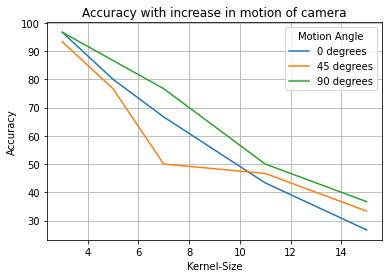

In [9]:
for idx,lst in enumerate(main_lst):
    plt.plot([3,5,7,11,15],[(item/30)*100 for item in lst],label = str(idx * 45) + " degrees")
    plt.xlabel("Kernel-Size")
    plt.ylabel("Accuracy")
plt.legend(title = "Motion Angle")
plt.grid()
plt.title("Accuracy with increase in motion of camera")
plt.show()